In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from   torch.autograd import Variable
print(torch.__version__)

1.0.1.post2


### Cohen, Dunbar, McClelland (CDM) 1990 paper training results

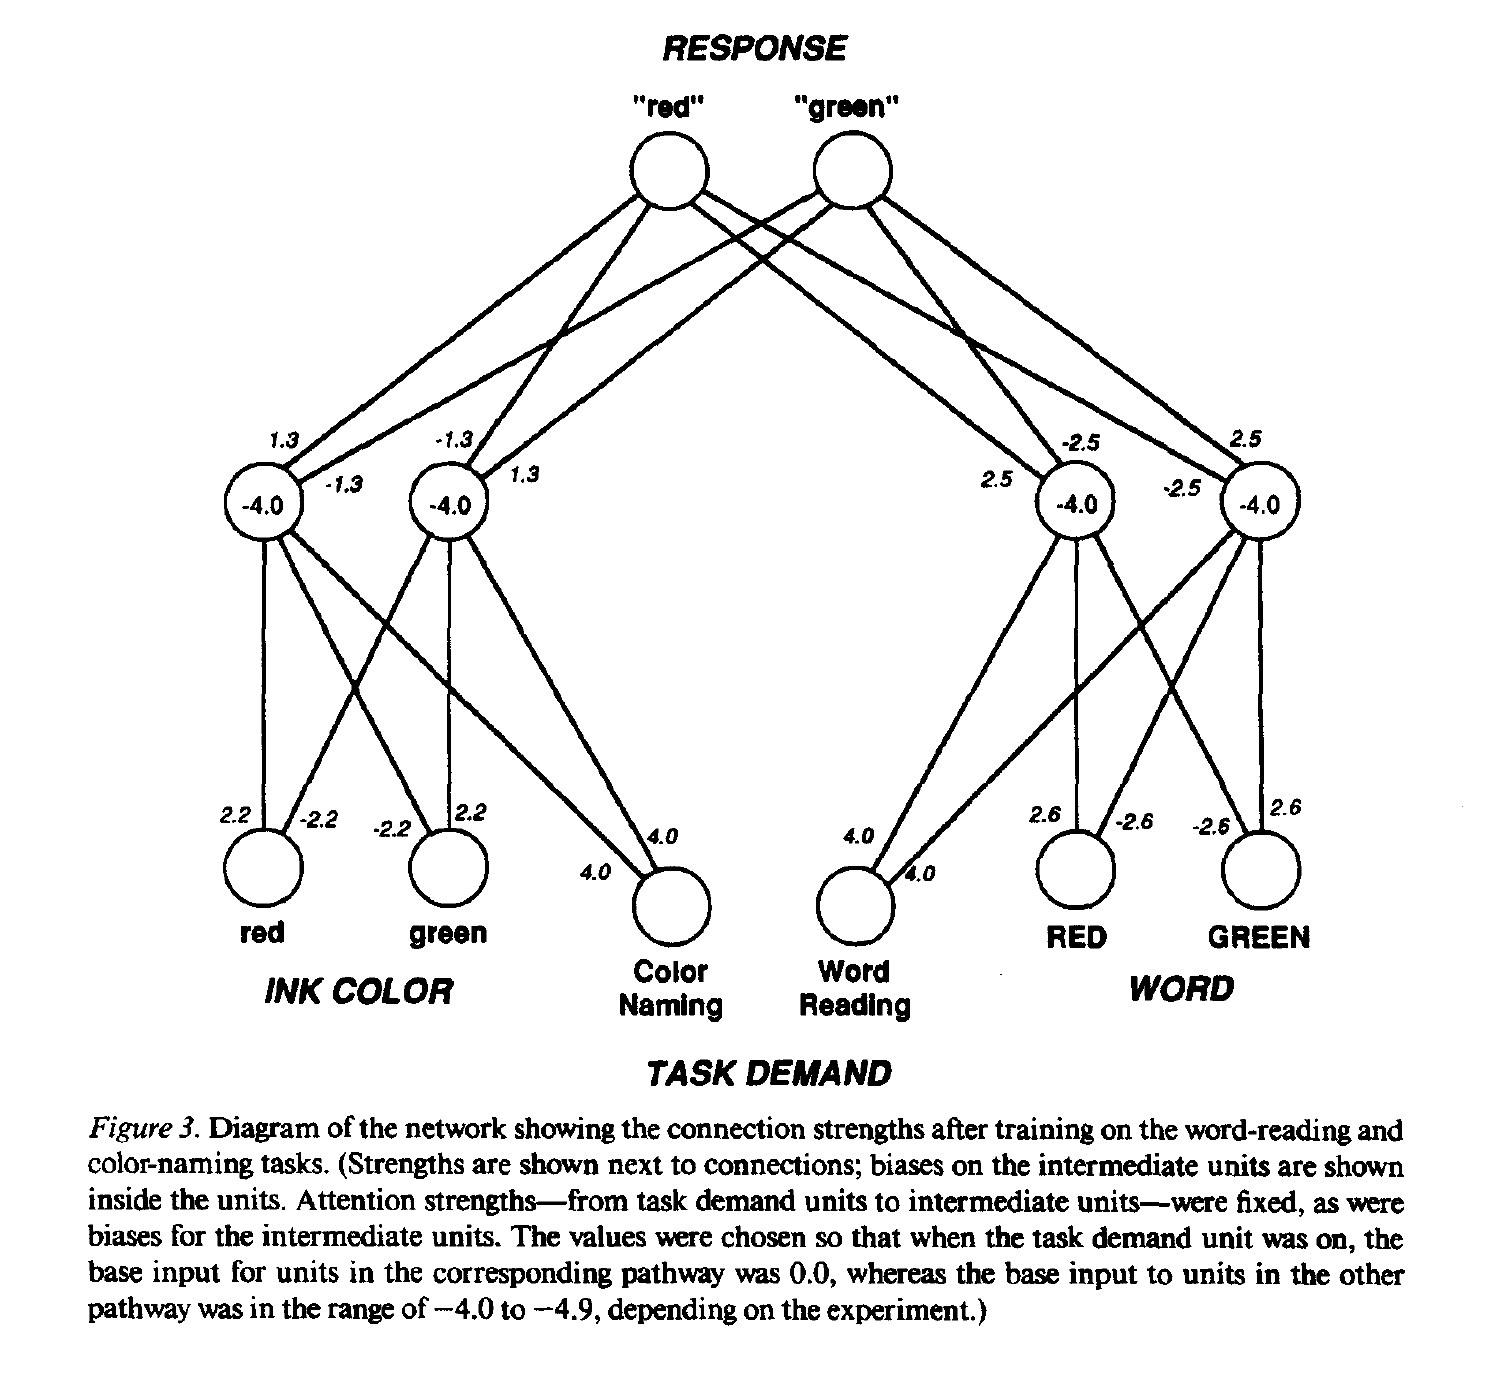

In [2]:
from IPython.display import Image
PATH = "/hidden/"
Image(filename = PATH + "stroop_task_training_diagram.png", width=450, height=450)

### dicts of input and target space
##### CN = color naming task, WR = word reading task

In [3]:
input_space  = {
    1:[[1,0,1],[0,0,0]],   # CN_input [color red = 1, green = 0, CN task = 1]
    2:[[0,1,1],[0,0,0]],   # CN_input [color red = 0, green = 1, CN task = 1]
    3:[[0,0,0],[1,0,1]],   # WR_input [color red = 1, green = 0, WR task = 1]
    4:[[0,0,0],[0,1,1]] }  # WR_input [color red = 0, green = 1, WR task = 1]

target_space = {
    1:[1,0],               # response red
    2:[0,1],               # response green
    3:[1,0], 
    4:[0,1] }

print(input_space)
print(target_space)

{1: [[1, 0, 1], [0, 0, 0]], 2: [[0, 1, 1], [0, 0, 0]], 3: [[0, 0, 0], [1, 0, 1]], 4: [[0, 0, 0], [0, 1, 1]]}
{1: [1, 0], 2: [0, 1], 3: [1, 0], 4: [0, 1]}


### generate the full training set according to the parameters in the CDM paper 
### (WR 10x more than CN), and check if the set is created properly

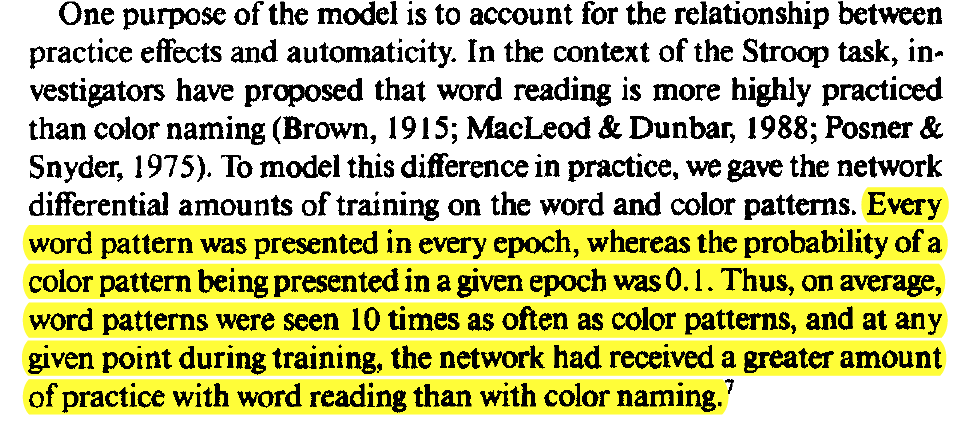

In [4]:
Image(filename = PATH + "ten to one.png", width=450, height=450)

In [5]:
def generate_training_set(input_or_target_space):      
    
    # convert dict to np.array
    idx1                   = np.arange(1,5)
    training_data_space    = []
    for key, value in input_or_target_space.items(): 
        if int(key) in idx1:
            training_data_space.append(value)
    training_data_space    = np.array(training_data_space)
    
    # set probability (word reading 10x more often than color naming)
    training_options       = np.array([1,2,3,4]) # [color red, green, word red, green]
    training_probabilities = np.array([1,1,10,10])
    training_set_template  = np.repeat(training_options, training_probabilities)
    training_set           = [training_data_space[idx2-1] for idx2 in training_set_template]
    return np.array(training_set)

# base training sets of dim: 1x22 (1 color red, 1 color green, 10 word red, 10 word green)
training_input  = generate_training_set(input_space)
training_target = generate_training_set(target_space)

# optional: increase size of training sets, here x5
temp_training_input  = []
temp_training_target = []
for idx3 in range(5):
    temp_training_input.append(training_input)
    temp_training_target.append(training_target)
training_input       = np.concatenate(temp_training_input)
training_target      = np.concatenate(temp_training_target)

# shuffle order of training inputs and targets (input-target mapping intact)
from sklearn.utils import shuffle
np.random.seed(12345) # initialize random state of the machine, can comment out if you want
training_input, training_target = shuffle(training_input, training_target)

# check if input-target mappings are correct
def double_check(training_input, training_target):
    for input_, target_ in zip(training_input, training_target):
        print('\ninput\n', input_, '\ntarget', target_)
double_check(training_input, training_target)


input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [0 1 1]] 
target [0 1]

input
 [[0 0 0]
 [1 0 1]] 
target [1 0]

input
 [[0 0 0]

### forward model

In [6]:
class stroop(nn.Module):
    def __init__(self):
        super().__init__()
        
        # nn.Linear applies a linear transformation to the input data: y = xA^T + b
        # y = output (hidden layer in this case, dim: 1x2)
        # x = input (input layer in this case, dim: 1x3)
        # A = initialized random weights based on input and output (^T = transpose, dim: 3x2)
        # b = bias (will update in the next version)
        self.CN_input_hidden = nn.Linear(in_features=3, out_features=2, bias=False)
        self.WR_input_hidden = nn.Linear(in_features=3, out_features=2, bias=False)
        self.hidden_output   = nn.Linear(in_features=4, out_features=2, bias=False)
        
        # one of the main contributions of the CDM 1990 paper - the sigmoid function
        self.activation_CN     = nn.Sigmoid()
        self.activation_WR     = nn.Sigmoid()
        self.activation_output = nn.Sigmoid()
        
    def forward(self, CN_input, WR_input):
        
        # for example:
        # take the CN_input (e.g., [1,0,1], dim: 1x3, in_features=3 in nn.Linear)
        # then dot product (3x2) with weight A (randomly initialized by nn.Linear)
        # which returns output values (e.g., [0.95 0.21], dim: 1x2, out_features=2)
        # then apply the activation function (nn.Sigmoid)
        # hidden1 (dim: 1x2) would then have the two values for the hidden layer units
        # [h1, h2] in the CN task section of the Figure 3 diagram in the paper 
        hidden_CN = self.activation_CN(self.CN_input_hidden(CN_input))
        hidden_WR = self.activation_WR(self.WR_input_hidden(WR_input))

        # now we concatenate hidden layer units/nodes for both the CN and WR tasks (dim: 1x4)
        hidden_total = torch.cat([hidden_CN, hidden_WR])
        
        # take the hidden values (dim: 1x4)
        # dot product (4x2) with weights which are initialized by the nn.Linear function
        # then apply the activation function (nn.Sigmoid)
        # which gives us the response output from the network (dim: 2x1)
        output = self.activation_output(self.hidden_output(hidden_total))
        
        return output

In [7]:
model = stroop()
# output __init__ parameter descriptions
model

stroop(
  (CN_input_hidden): Linear(in_features=3, out_features=2, bias=False)
  (WR_input_hidden): Linear(in_features=3, out_features=2, bias=False)
  (hidden_output): Linear(in_features=4, out_features=2, bias=False)
  (activation_CN): Sigmoid()
  (activation_WR): Sigmoid()
  (activation_output): Sigmoid()
)

In [8]:
model_parameters = model.parameters()
# the parameters in nn.Linear are just the weights because `bias=False`
list(model_parameters)

[Parameter containing:
 tensor([[-0.1400,  0.5222,  0.2749],
         [ 0.4933,  0.3546,  0.3585]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1085,  0.1134,  0.3178],
         [ 0.4628,  0.2683, -0.5639]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1814, -0.2576, -0.1022,  0.4421],
         [-0.3926, -0.3812, -0.2333, -0.2414]], requires_grad=True)]

### set up training parameters, the loss function, and train the network!

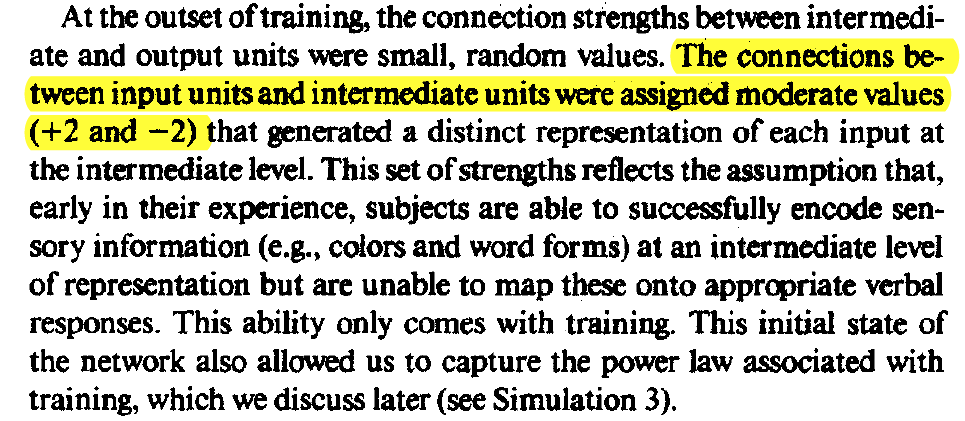

In [9]:
Image(filename = PATH + "two and neg two.png", width=450, height=450)

In [10]:
model = stroop()

# re-initialize some of the init parameters according to the CDM paper
w_CN_input_hidden = np.random.choice([-2,2], size=(2,3))
w_CN_input_hidden = torch.tensor(w_CN_input_hidden, dtype=torch.float)
model.CN_input_hidden.weight.data = w_CN_input_hidden

w_WR_input_hidden = np.random.choice([-2,2], size=(2,3))
w_WR_input_hidden = torch.tensor(w_WR_input_hidden, dtype=torch.float)
model.WR_input_hidden.weight.data = w_WR_input_hidden

# stochastic gradient descent (SGD) adds some noise to the direction so we don't get stuck
# in the same local minimum; gradient being the derivative of the activation function
optimizer = optim.SGD(model.parameters(), lr=1e-1)

# calculate loss using MSE (criterion is the term/convention in pytorch for loss/error)
criterion = nn.MSELoss()

# run model - iterate ___/many times, here x500 epochs
weights = []
losses = []
iterations = 500
for epoch in range(iterations):
    for inputs, targets in zip(training_input, training_target):
        
        # pytorch doesn't work with numpy array - only a special kind of tensor: Variable
        # input_ = inputs = training_input
        # e.g., [[0 0 0],[1 0 1]], where input_[0] = [0 0 0] and input_[1] = [1 0 1]
        input_ = Variable(torch.tensor(inputs, dtype=torch.float))
        target = Variable(torch.tensor(targets, dtype=torch.float))
        
        # run the forward model
        output = model(input_[0], input_[1])
        
        # zero the gradient buffers/set gradients to zero so previous runs don't interfere
        optimizer.zero_grad()
        
        # compute the loss between the target (e.g., [1,0]) and output (e.g., [0.99,0.12]) 
        loss = criterion(output, target)        
        
        # calculate the gradient change (how much it moves down towards the minimum) 
        # for each of the weights
        loss.backward()
        
        # multiply the learning rate (lr) with the gradients and subtract that from the 
        # original weights = how weights are updated
        optimizer.step() 
        
    # print losses for each epoch and save them
    print(epoch, loss.data)
    
    # save losses and weights for each epoch
    losses.append(loss.data.numpy())
    weights.append([model.CN_input_hidden.weight.data.numpy().copy(),
                    model.WR_input_hidden.weight.data.numpy().copy(),
                    model.hidden_output.weight.data.numpy().copy()])

0 tensor(0.1695)
1 tensor(0.1332)
2 tensor(0.1091)
3 tensor(0.0914)
4 tensor(0.0777)
5 tensor(0.0668)
6 tensor(0.0580)
7 tensor(0.0506)
8 tensor(0.0446)
9 tensor(0.0395)
10 tensor(0.0353)
11 tensor(0.0318)
12 tensor(0.0288)
13 tensor(0.0263)
14 tensor(0.0241)
15 tensor(0.0223)
16 tensor(0.0207)
17 tensor(0.0193)
18 tensor(0.0181)
19 tensor(0.0170)
20 tensor(0.0161)
21 tensor(0.0152)
22 tensor(0.0145)
23 tensor(0.0138)
24 tensor(0.0132)
25 tensor(0.0126)
26 tensor(0.0121)
27 tensor(0.0116)
28 tensor(0.0112)
29 tensor(0.0108)
30 tensor(0.0104)
31 tensor(0.0100)
32 tensor(0.0097)
33 tensor(0.0094)
34 tensor(0.0091)
35 tensor(0.0088)
36 tensor(0.0086)
37 tensor(0.0083)
38 tensor(0.0081)
39 tensor(0.0079)
40 tensor(0.0077)
41 tensor(0.0075)
42 tensor(0.0073)
43 tensor(0.0071)
44 tensor(0.0070)
45 tensor(0.0068)
46 tensor(0.0066)
47 tensor(0.0065)
48 tensor(0.0063)
49 tensor(0.0062)
50 tensor(0.0061)
51 tensor(0.0060)
52 tensor(0.0058)
53 tensor(0.0057)
54 tensor(0.0056)
55 tensor(0.0055)
56

### see some results!

##### print out the desired outcome (target) and the last output of the trained network (model(input) = output)

In [11]:
for inputs, targets in zip(training_input, training_target):
    target  = Variable(torch.tensor(targets, dtype=torch.float))
    input_  = Variable(torch.tensor(inputs, dtype=torch.float))
    print(target, model(input_[0], input_[1]))

tensor([0., 1.]) tensor([0.0199, 0.9806], grad_fn=<SigmoidBackward>)
tensor([1., 0.]) tensor([0.9787, 0.0216], grad_fn=<SigmoidBackward>)
tensor([1., 0.]) tensor([0.9787, 0.0216], grad_fn=<SigmoidBackward>)
tensor([0., 1.]) tensor([0.0199, 0.9806], grad_fn=<SigmoidBackward>)
tensor([0., 1.]) tensor([0.0199, 0.9806], grad_fn=<SigmoidBackward>)
tensor([1., 0.]) tensor([0.9787, 0.0216], grad_fn=<SigmoidBackward>)
tensor([0., 1.]) tensor([0.0199, 0.9806], grad_fn=<SigmoidBackward>)
tensor([1., 0.]) tensor([0.9787, 0.0216], grad_fn=<SigmoidBackward>)
tensor([0., 1.]) tensor([0.0199, 0.9806], grad_fn=<SigmoidBackward>)
tensor([0., 1.]) tensor([0.0199, 0.9806], grad_fn=<SigmoidBackward>)
tensor([1., 0.]) tensor([0.9787, 0.0216], grad_fn=<SigmoidBackward>)
tensor([1., 0.]) tensor([0.9787, 0.0216], grad_fn=<SigmoidBackward>)
tensor([1., 0.]) tensor([0.9787, 0.0216], grad_fn=<SigmoidBackward>)
tensor([0., 1.]) tensor([0.0199, 0.9806], grad_fn=<SigmoidBackward>)
tensor([0., 1.]) tensor([0.0199, 0

##### plot inputs to hidden weight changes over epochs

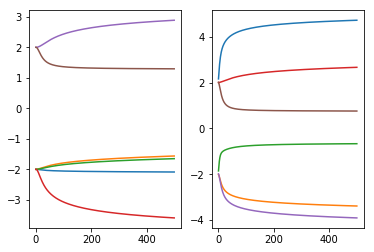

In [12]:
plot_weights_CN = []
plot_weights_WR = []

for CN_hidden, WR_hidden, hidden_output in weights:
    plot_weights_CN.append(CN_hidden)
    plot_weights_WR.append(WR_hidden)
    
plot_weights_CN = np.array(plot_weights_CN).reshape(iterations,-1)
plot_weights_WR = np.array(plot_weights_WR).reshape(iterations,-1)

fig, (ax1, ax2) = plt.subplots(1,2)
for idx1 in range(plot_weights_CN.shape[1]):
    ax1.plot(plot_weights_CN[:,idx1])
    ax2.plot(plot_weights_WR[:,idx1])

##### plot hidden to response weight changes over epochs

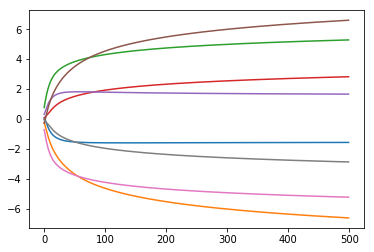

In [13]:
plot_weights_HR = []

for CN_hidden, WR_hidden, hidden_output in weights:
    plot_weights_HR.append(hidden_output)

plot_weights_HR = np.array(plot_weights_HR).reshape(iterations,-1)

fig, ax = plt.subplots()
for idx1 in range(plot_weights_HR.shape[1]):
    ax.plot(plot_weights_HR[:,idx1])

##### plot loss changes over epochs

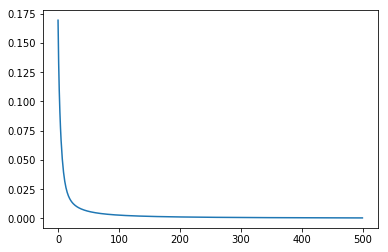

In [14]:
plt.plot(np.array(losses))

##### summary of final weights and example of an input and output vs target

In [15]:
# final weights from input to hidden units 
# (i.e. [red to h1, red to h2, CN task to h1],
#       [green to h1, green to h2, CN task to h2])
print(model.CN_input_hidden.weight)

# final weights from input to hidden units 
# (i.e. [red to h3, red to h4, WN task to h3],
#       [green to h3, green to h4, WN task to h4)
print(model.WR_input_hidden.weight)

# final weights from hidden units to responses 
# (i.e. [h1 to red, h2 to red, h3 to red, h4 to red],
#       [h1 to green, h2 to green, h3 to green, h4 to green])
print(model.hidden_output.weight)

print()
# one of the inputs, its target, and output from model
print(input_, target, output)

Parameter containing:
tensor([[-2.0873, -1.5630, -1.6503],
        [-3.5922,  2.8869,  1.2947]], requires_grad=True)
Parameter containing:
tensor([[ 4.7184, -3.3881, -0.6697],
        [ 2.6639, -3.9082,  0.7558]], requires_grad=True)
Parameter containing:
tensor([[-1.5752, -6.6283,  5.2866,  2.8221],
        [ 1.6581,  6.6038, -5.2417, -2.8817]], requires_grad=True)

tensor([[0., 0., 0.],
        [1., 0., 1.]]) tensor([1., 0.]) tensor([0.9787, 0.0216], grad_fn=<SigmoidBackward>)


### test phase!

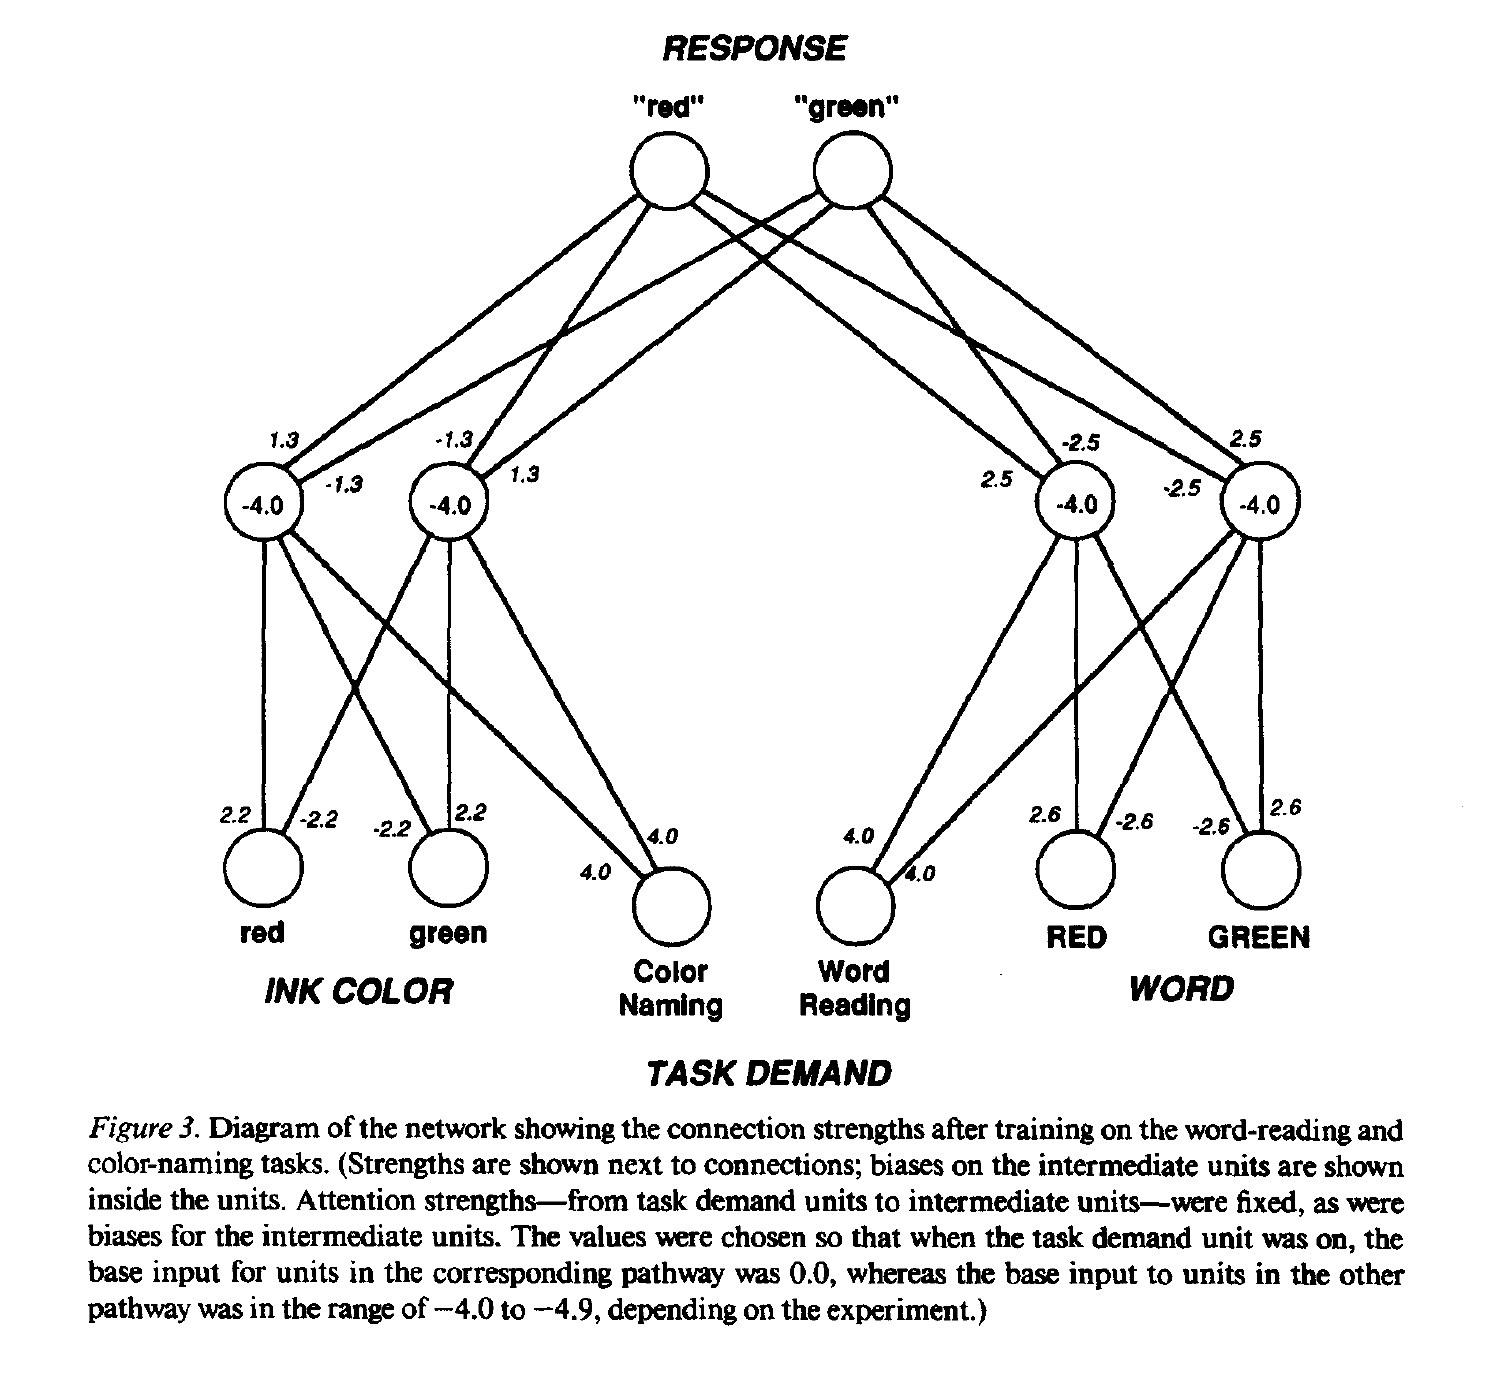

In [16]:
Image(filename = PATH + "stroop_task_training_diagram.png", width=400, height=400)

In [17]:
# all possible inputs, with training (1~4) data excluding congruent/conflict stimuli

input_test = {
    1:[[1,0,1],[0,0,0]],  # color red, color naming (CN) task
    2:[[0,1,1],[0,0,0]],  # color green, color naming task
    3:[[0,0,0],[1,0,1]],  # color red, word reading (WR) task
    4:[[0,0,0],[0,1,1]],
    
    5:[[1,0,1],[1,0,0]],  # 5 color red, word red, color naming task - congruent
    6:[[0,1,1],[0,1,0]],  # 6 color green, word green, color naming task - congruent  
    7:[[1,0,0],[1,0,1]],  # 7 color red, word red, word reading task - congruent
    8:[[0,1,0],[0,1,1]],  # 8 color green, word green, word reading task - congruent
    
    9: [[1,0,1],[0,1,0]], # 9 color red, word green, color naming task - conflict
    10:[[0,1,1],[1,0,0]], # 10 color green, word red, color naming task - conflict
    11:[[1,0,0],[0,1,1]], # 11 color red, word green, word reading task - conflict
    12:[[0,1,0],[1,0,1]]  # 12 color green, word red, word reading task - conflict 
}

input_test_description = {
    1: "color red, color naming (CN) task",
    2: "color green, color naming (CN) task",
    3: "color red, word reading (WR) task",
    4: "color green, word reading (WR) task",
    
    5: "color red, word red, color naming task - congruent",
    6: "color green, word green, color naming task - congruent",  
    7: "color red, word red, word reading task - congruent",
    8: "color green, word green, word reading task - congruent",
    
    9:  "color red, word green, color naming task - conflict",
    10: "color green, word red, color naming task - conflict",
    11: "color red, word green, word reading task - conflict",
    12: "color green, word red, word reading task - conflict"
}
 
output_test = {
    1:[1,0],                 # response red
    2:[0,1],                 # response green
    3:[1,0], 
    4:[0,1], 

    5:[1,0],                 # 5 correct response red
    6:[0,1],                 # 6 correct response green
    7:[1,0],                 # 7 correct response red
    8:[0,1],                 # 8 correct response green      
    9:[1,0],                 # 9 correct response red
    10:[0,1],                # 10 correct response green
    11:[1,0],                # 11 correct response red
    12:[0,1]                 # 12 correct response green 
}

output_test_description = {
    '{},{}'.format(1,0): "red",
    '{},{}'.format(0,1): "green"
}

for key, value in input_test.items():
    # f'' {key:2} will always you 2 spaces, 
    # e.g. {variable:.2f} = will give you 2 decimal places
    print(f'{key:2}', value, output_test[key])
    # another option (more commonly used, since it's the string format)
    # print('{:2}'.format(key), value, output_test[key])

 1 [[1, 0, 1], [0, 0, 0]] [1, 0]
 2 [[0, 1, 1], [0, 0, 0]] [0, 1]
 3 [[0, 0, 0], [1, 0, 1]] [1, 0]
 4 [[0, 0, 0], [0, 1, 1]] [0, 1]
 5 [[1, 0, 1], [1, 0, 0]] [1, 0]
 6 [[0, 1, 1], [0, 1, 0]] [0, 1]
 7 [[1, 0, 0], [1, 0, 1]] [1, 0]
 8 [[0, 1, 0], [0, 1, 1]] [0, 1]
 9 [[1, 0, 1], [0, 1, 0]] [1, 0]
10 [[0, 1, 1], [1, 0, 0]] [0, 1]
11 [[1, 0, 0], [0, 1, 1]] [1, 0]
12 [[0, 1, 0], [1, 0, 1]] [0, 1]


In [18]:
for key, value in input_test.items():
    
    input_ = Variable(torch.tensor(value, dtype=torch.float))
    target = Variable(torch.tensor(output_test[key], dtype=torch.float))
    output = model(input_[0], input_[1])
    target = target.detach().numpy()
    print(target, output.detach().numpy().copy(),input_test_description[key],
         output_test_description['{},{}'.format(int(target[0]),int(target[1]))])  

[1. 0.] [0.96808887 0.03167607] color red, color naming (CN) task red
[0. 1.] [0.07343271 0.9246235 ] color green, color naming (CN) task green
[1. 0.] [0.97868747 0.02164184] color red, word reading (WR) task red
[0. 1.] [0.01991382 0.98061657] color green, word reading (WR) task green
[1. 0.] [9.9928039e-01 7.1136316e-04] color red, word red, color naming task - congruent red
[0. 1.] [0.00172425 0.9982399 ] color green, word green, color naming task - congruent green
[1. 0.] [9.9948823e-01 5.0913368e-04] color red, word red, word reading task - congruent red
[0. 1.] [0.00175136 0.99823016] color green, word green, word reading task - congruent green
[1. 0.] [0.39801228 0.60198474] color red, word green, color naming task - conflict red
[0. 1.] [0.7839177  0.21069874] color green, word red, color naming task - conflict green
[1. 0.] [0.4635878  0.53810567] color red, word green, word reading task - conflict red
[0. 1.] [0.7985942  0.19783305] color green, word red, word reading task -